POSIBLES SOLUCIONES AL PROBLEMA:

- ELIMINAR LOS OUTLIERS Y STANDARIZAR LOS DATOS CLASIFICAR LOS OUTLIERS COMO POSITIVOS O NEGATIVOS PARA EL CUESTIONARIO FINAL
OJO LAS VARIABLES FORMAT FILL RATE Y OTROS %, VER SI SE QUITAN

- PARA EL CUESTIONARIO FINAL, DEFINIR RANGOS DE LAS VARIABLES DE UN CLUSTER, POR EJEMPLO, CPM CLUSTER 1 ENTRE 1 Y 3, PARA RECOMENDAR UNO U OTRO

- TRANSFORMACIÓN LOGARITIMICA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pickle
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer



pd.options.display.float_format = '{:.2f}'.format #So the numbers will not appear in a scientific format

# !pip install pyclustertend
# !pip install kmodes
# !pip install gower
# !pip install prince
#!pip install --user mca
#!pip install apyori

C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [62]:
def results_evaluation(model, data):

    #This function has 2 arguments:
    #-model: to define de Clusters and the scores
    #-data: the data I´m working with, to calculate the scores
  

    print('CLUSTERING DIVISION:\n', pd.DataFrame(model.labels_)[0].value_counts())
    
    new_df = groupby_domains.copy()
    new_df['Cluster'] = model.labels_
    display(new_df.groupby('Cluster').mean())
    
    print('The Silhouette Score is: ', silhouette_score(data, model.labels_, metric='euclidean'))
    print('The Calinski Harabasz Score is: ', calinski_harabasz_score(data, model.labels_))
    print('The Davies Douldin Score is: ', davies_bouldin_score(data, model.labels_))


In [47]:
groupby_domains.drop(['Domain','Format Loads', 'Impressions', 'Clicks',
                                                   'Viewability Rate', 'Efficiency Rate', 'Category importance',
                                                         '50% View Rate', 'Country'], 1)

,Format Fill Rate,CPM,CTR,Category,Country,Geographical zone
0,0.60,1.59,0.46,Health & Wellness,Turkey,West Europe
1,10.81,1.71,0.07,News & Portals,United States,North America
2,3.77,1.44,0.39,Sports,Peru,South America
3,1.14,1.73,0.40,News & Portals,Egypt,Africa
4,19.54,1.80,0.79,News & Portals,Taiwan,Asia
...,...,...,...,...,...,...
896,0.13,1.89,0.10,News & Portals,Nicaragua,South America
897,0.20,1.25,0.05,Money & Investing,United States,North America
898,13.72,1.70,0.20,News & Portals,United Kingdom,West Europe
899,1.14,1.59,0.00,Leisure,Germany,West Europe


In [59]:
famd = prince.FAMD(n_components=6)
famd = famd.fit_transform(groupby_domains.drop(['Domain','Format Loads', 'Impressions', 'Clicks',
                                                   'Viewability Rate', 'Efficiency Rate', 'Category importance',
                                                         '50% View Rate'], 1))

In [64]:
kmeans_pca_minmax= KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_pca_minmax.fit(famd)
results_evaluation(kmeans_pca_minmax, famd)

CLUSTERING DIVISION:
 2    303
1    286
0    194
3    118
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance
Cluster,,,,,,,,,,
0,112384.32,13421.98,12.35,72.54,84.25,1.49,74.47,0.56,66.38,4.36
1,120915.15,11953.75,10.59,78.76,87.37,1.57,86.98,0.69,71.12,58.61
2,118352.98,8909.71,9.52,68.49,79.60,1.40,46.48,0.47,59.55,25.53
3,145497.76,8255.16,7.47,72.26,84.67,1.53,44.54,0.39,61.15,27.91


The Silhouette Score is:  0.42652640749916704
The Calinski Harabasz Score is:  396.3460544668657
The Davies Douldin Score is:  1.1196203443057529


# MCA

In [ ]:
mca.exp

In [17]:
groupby_domains[['Category', 'Country', 'Geographical zone']]

,Category,Country,Geographical zone
0,Health & Wellness,Turkey,West Europe
1,News & Portals,United States,North America
2,Sports,Peru,South America
3,News & Portals,Egypt,Africa
4,News & Portals,Taiwan,Asia
...,...,...,...
896,News & Portals,Nicaragua,South America
897,Money & Investing,United States,North America
898,News & Portals,United Kingdom,West Europe
899,Leisure,Germany,West Europe


In [ ]:
groupby_domains[['Country', 'Geographical zone']]

In [102]:
import prince

X = groupby_domains[['Country', 'Geographical zone', 'Country']]
mca = prince.MCA(n_components=3)

mca = pd.DataFrame(mca.fit_transform(X))

print(mca)


        0     1     2
0    0.90 -0.36 -1.45
1   -0.87 -0.44  1.18
2   -0.22 -0.39  0.22
3    1.35  0.21 -5.73
4    1.36  0.06  0.73
..    ...   ...   ...
896 -0.22 -0.40  0.19
897 -0.87 -0.44  1.18
898  0.91 -0.34 -1.51
899  0.93 -0.35 -1.50
900 -1.52  2.30 -0.64

[901 rows x 3 columns]


In [99]:
groupby_domains_clustering= groupby_domains.drop(['Domain','Format Loads', 'Impressions', 'Clicks',
                                                   'Viewability Rate', 'Efficiency Rate', 'Category importance',
                                                         '50% View Rate', 'Country', 'Geographical zone', 'Country','Category'], 1)

In [109]:
X = groupby_domains_clustering.merge(mca,how='outer', left_index=True, right_index=True )


In [111]:
kmeans_pca_minmax= KMeans(n_clusters=6, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_pca_minmax.fit(X)
results_evaluation(kmeans_pca_minmax, X)

CLUSTERING DIVISION:
 4    339
0    264
3    164
1    105
5     27
2      2
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance
Cluster,,,,,,,,,,
0,121702.25,9111.96,7.55,74.68,85.98,1.52,57.34,0.57,67.03,32.74
1,115865.09,24447.23,24.73,77.54,91.48,1.56,157.02,0.53,71.92,31.36
2,31505.03,31582.52,98.81,79.93,96.84,1.77,127.98,0.48,78.93,30.29
3,121288.94,14740.74,15.11,77.67,91.18,1.56,97.50,0.64,70.43,34.21
4,123297.04,2594.90,2.03,67.88,75.25,1.40,16.42,0.50,57.49,29.81
5,124691.07,50501.85,45.81,78.23,91.87,1.64,193.67,0.41,75.35,34.23


The Silhouette Score is:  0.4448029553401215
The Calinski Harabasz Score is:  1904.834792011066
The Davies Douldin Score is:  0.6237785352798612


# K MEANS WITH ONE HOT ENCODING

In [3]:
groupby_domains = pd.read_csv('DATA/Global groupby_domains.csv')

In [34]:
groupby_domains_one_hot =pd.get_dummies(groupby_domains,columns=['Category','Geographical zone'])

In [4]:
groupby_domains.head(1)

,Domain,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,25% View Rate,50% View Rate,75% View Rate,100% View Rate,Category,Category importance,Country
0,memurlar.net,2739246.93,8942.44,0.60,83.80,92.72,1.59,46.82,0.46,79.04,67.91,59.93,53.49,Health & Wellness,2.08,Turkey


In [38]:
groupby_domains_clustering= groupby_domains_one_hot.drop(['Domain','Format Loads', 'Impressions', 'Clicks',
                                                   'Viewability Rate', 'Efficiency Rate', 'Category importance', 'Country',
                                                         '50% View Rate'], 1)


In [40]:
robust = pd.DataFrame(RobustScaler().fit_transform(groupby_domains_clustering))
pca_2_robust = pd.DataFrame(PCA(n_components = 2).fit_transform(robust))
standardscaler = pd.DataFrame(StandardScaler().fit_transform(groupby_domains_clustering))
minmax = pd.DataFrame(MinMaxScaler().fit_transform(groupby_domains_clustering))
pca_2_groupby_domains = pd.DataFrame(PCA(n_components = 2).fit_transform(groupby_domains_clustering))


In [46]:
minmax = pd.DataFrame(MinMaxScaler().fit_transform(groupby_domains_clustering.drop(['Category', 'Country'], 1)))
minmax['Country'] = groupby_domains_clustering['Country'].copy()
minmax['Category'] = groupby_domains_clustering['Category'].copy()



Text(0, 0.5, 'Cumulative explained variance')

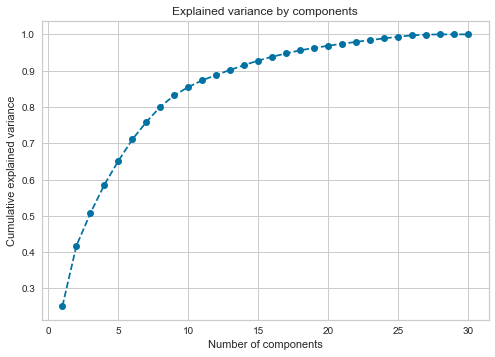

In [42]:
pca = PCA()
pca.fit(minmax)
plt.plot(range(1,31), pca.explained_variance_ratio_.cumsum(), marker= 'o' , linestyle = '--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

 A rule of thumb is to preserve around 80 % of the variance. So, in this instance, I decide to keep 4 components. I´ll perform PCA with the chosen number of components.

In [43]:
pca_minmax = PCA(n_components=10)
pca_minmax = pca_minmax.fit_transform(minmax)

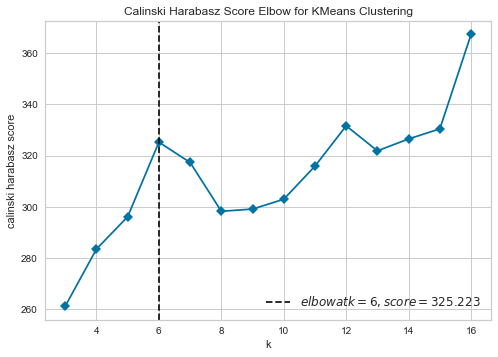

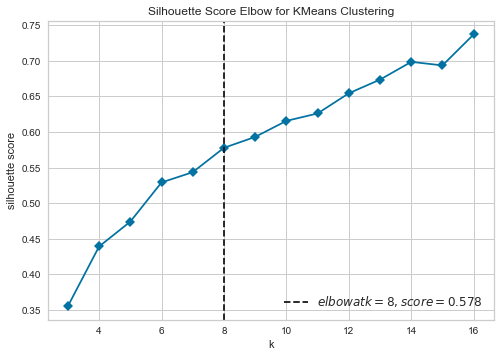

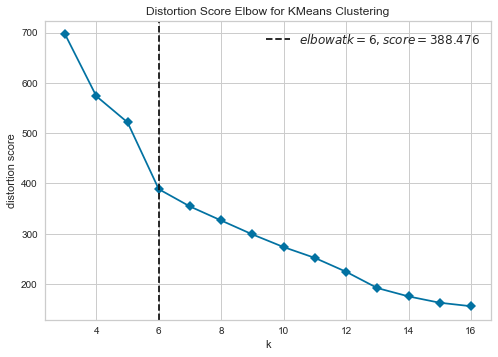

In [44]:
model = KMeans(init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
visualization_clusters(pca_minmax, model)

- Initializing the KElbowVisualizer several times with the 3 kind of metrics (distortion, Silhouette and calinski_harabasz) the optimal number of clusters is between 5-7

In [54]:
kmeans_pca_minmax= KMeans(n_clusters=6, init='k-means++', max_iter=1000, n_init=5, algorithm='auto')
kmeans_pca_minmax.fit(pca_minmax)
results_evaluation(kmeans_pca_minmax, pca_minmax)

CLUSTERING DIVISION:
 1    308
4    195
3    118
0    108
5     94
2     78
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance
Cluster,,,,,,,,,,
0,122016.61,7989.56,10.10,72.09,83.66,1.46,56.09,0.54,62.94,25.69
1,127470.05,11543.74,10.17,78.19,86.93,1.56,83.74,0.68,70.49,58.61
2,120713.43,15860.85,15.12,65.77,79.01,1.48,55.89,0.35,57.92,19.30
3,145497.76,8255.16,7.47,72.26,84.67,1.53,44.54,0.39,61.15,27.91
4,112489.49,13355.89,12.29,72.60,84.30,1.49,74.11,0.56,66.35,4.37
5,89952.96,4919.02,5.42,65.91,74.91,1.26,29.22,0.47,56.37,22.97


The Silhouette Score is:  0.5290886675806757
The Calinski Harabasz Score is:  325.2226290541741
The Davies Douldin Score is:  1.0698072411076278


In [60]:
pca_minmax_onehot= groupby_domains.copy()
pca_minmax_onehot['Cluster'] = kmeans_pca_minmax.labels_


In [ ]:
sv = SilhouetteVisualizer(kmeans_pca_robustscaler)
sv.fit(pca_robustscaler)
sv.show()

# K MEDOIDS ONE HOT ENCODING

In [119]:
%run KMEDOIDS.py

In [113]:
groupby_domains_one_hot =pd.get_dummies(groupby_domains,columns=['Category','Geographical zone'])

In [114]:
groupby_domains_clustering= groupby_domains_one_hot.drop(['Domain','Format Loads', 'Impressions', 'Clicks',
                                                   'Viewability Rate', 'Efficiency Rate', 'Category importance', 'Country',
                                                         '50% View Rate'], 1)


In [115]:
groupby_domains_clustering

,Format Fill Rate,CPM,CTR,Category_Autos,Category_B-to-B,Category_Casual Games,Category_Community & Culture,Category_Education & Careers,Category_Family & Parenting,Category_Food,...,Category_Tech & Gaming,Category_Travel,Geographical zone_Africa,Geographical zone_Arabia,Geographical zone_Asia,Geographical zone_Australia,Geographical zone_East Europe,Geographical zone_North America,Geographical zone_South America,Geographical zone_West Europe
0,0.60,1.59,0.46,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,10.81,1.71,0.07,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3.77,1.44,0.39,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1.14,1.73,0.40,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,19.54,1.80,0.79,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,0.13,1.89,0.10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
897,0.20,1.25,0.05,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
898,13.72,1.70,0.20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
899,1.14,1.59,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [121]:
def visualization_clusters(data, clustering_model):

    # calinski_harabasz and silhouette scores visualization
    visualizer1 = KElbowVisualizer(
        clustering_model, k=(3,17), metric='calinski_harabasz', timings=False
    )

    visualizer1.fit(data)        # Fit the data to the visualizer
    visualizer1.show()        # Finalize and render the figure

    visualizer2 = KElbowVisualizer(
        clustering_model, k=(3,17), metric='silhouette', timings=False
    )

    visualizer2.fit(data)        # Fit the data to the visualizer
    visualizer2.show()        # Finalize and render the figure
    
    visualizer3 = KElbowVisualizer(
    clustering_model, k=(3,17), metric='distortion', timings=False
    )

    visualizer3.fit(data)        # Fit the data to the visualizer
    visualizer3.show()        # Finalize and render the figure

In [134]:
groupby_domains_clustering

,Format Fill Rate,CPM,CTR,Category_Autos,Category_B-to-B,Category_Casual Games,Category_Community & Culture,Category_Education & Careers,Category_Family & Parenting,Category_Food,...,Category_Tech & Gaming,Category_Travel,Geographical zone_Africa,Geographical zone_Arabia,Geographical zone_Asia,Geographical zone_Australia,Geographical zone_East Europe,Geographical zone_North America,Geographical zone_South America,Geographical zone_West Europe
0,0.60,1.59,0.46,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,10.81,1.71,0.07,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3.77,1.44,0.39,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1.14,1.73,0.40,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,19.54,1.80,0.79,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,0.13,1.89,0.10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
897,0.20,1.25,0.05,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
898,13.72,1.70,0.20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
899,1.14,1.59,0.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


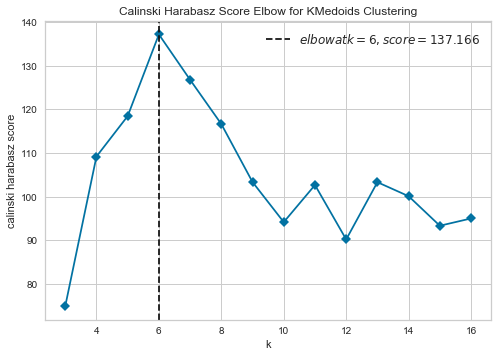

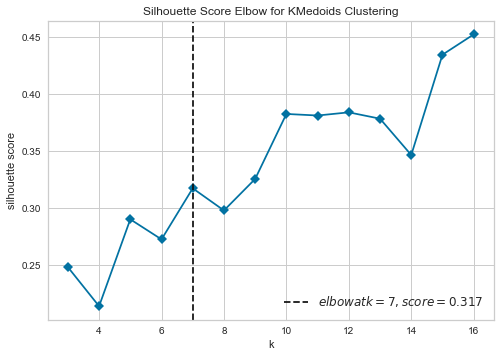

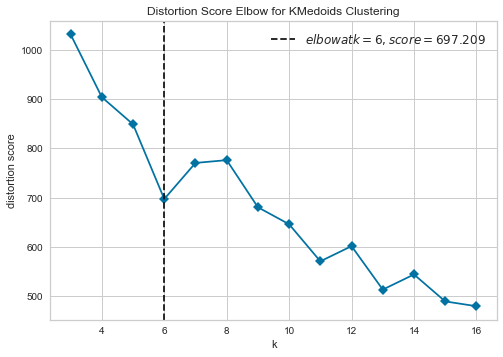

In [133]:
# Instantiate the clustering model and visualizer
model = KMedoids(init= 'k-medoids++')

visualization_clusters(minmax,model)

In [132]:
kmedoids_robust = KMedoids(n_clusters = 6, init= 'k-medoids++')
kmedoids_robust.fit(groupby_domains_clustering)
results_evaluation(kmedoids_robust, groupby_domains_clustering )

CLUSTERING DIVISION:
 4    334
0    247
2    155
5    120
1     37
3      8
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance
Cluster,,,,,,,,,,
0,116578.70,8527.32,7.21,74.64,85.73,1.52,56.55,0.58,66.79,32.71
1,147137.91,43087.97,37.55,77.94,92.68,1.63,146.53,0.41,75.22,32.37
2,125931.87,13324.00,13.70,76.83,90.52,1.56,83.10,0.63,69.98,33.81
3,88868.39,57536.09,69.70,84.98,97.55,1.76,363.08,0.60,80.95,30.90
4,123641.25,2554.23,1.99,67.86,75.15,1.40,16.08,0.50,57.37,29.87
5,113736.44,21810.52,22.31,77.54,91.04,1.53,151.00,0.56,71.17,32.45


The Silhouette Score is:  0.4694102664119379
The Calinski Harabasz Score is:  2145.8809618173464
The Davies Douldin Score is:  0.6483269644592421


## KPrototypes

In [13]:
def visualization_clusters(data, clustering_model):

    # calinski_harabasz and silhouette scores visualization
    visualizer1 = KElbowVisualizer(
        clustering_model, k=(3,17), metric='calinski_harabasz', timings=False
    )

    visualizer1.fit(data)        # Fit the data to the visualizer
    visualizer1.show()        # Finalize and render the figure

    visualizer2 = KElbowVisualizer(
        clustering_model, k=(3,17), metric='silhouette', timings=False
    )

    visualizer2.fit(data)        # Fit the data to the visualizer
    visualizer2.show()        # Finalize and render the figure
    
    visualizer3 = KElbowVisualizer(
    clustering_model, k=(3,17), metric='distortion', timings=False
    )

    visualizer3.fit(data)        # Fit the data to the visualizer
    visualizer3.show()        # Finalize and render the figure

In [51]:
def results_evaluation(model, data):

    #This function has 2 arguments:
    #-model: to define de Clusters and the scores
    #-data: the data I´m working with, to calculate the scores
  

    print('CLUSTERING DIVISION:\n', pd.DataFrame(model.labels_)[0].value_counts())
    
    new_df = groupby_domains.copy()
    new_df['Cluster'] = model.labels_
    display(new_df.groupby('Cluster').mean())
    
    print('The Silhouette Score is: ', silhouette_score(data, model.labels_, metric='euclidean'))
    print('The Calinski Harabasz Score is: ', calinski_harabasz_score(data, model.labels_))
    print('The Davies Douldin Score is: ', davies_bouldin_score(data, model.labels_))


In [135]:
from kmodes.kprototypes import KPrototypes

- With PCA


<function matplotlib.pyplot.show(*args, **kw)>

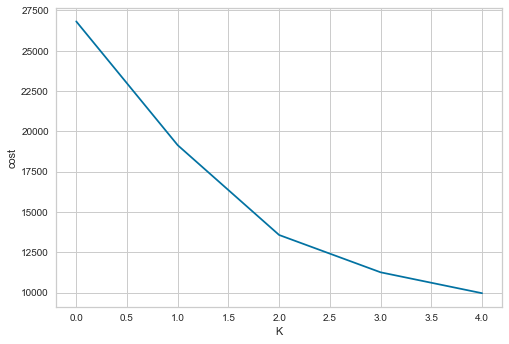

In [255]:
pca = pd.DataFrame(PCA(n_components=1).fit_transform(groupby_domains[['Format Fill Rate', 'CPM', 'CTR' ]]))
pca['Geographical zone'] = groupby_domains['Geographical zone'].copy()
pca['Category'] = groupby_domains['Category'].copy()

#Choosing optimal K value
cost = []
for num_clusters in list(range(3,8)):
    kproto = KPrototypes(n_clusters=num_clusters) 
    kproto.fit_predict(pca, categorical=[1,2])
    cost.append(kproto.cost_)

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

In [261]:
k_pro_pca = KPrototypes(n_clusters=4)
k_pro_pca.fit(pca, categorical = [1,2])
results_evaluation_kpro(k_pro_pca, pca)

print('The Silhouette Score is: ', silhouette_score(pca.drop(['Category','Geographical zone'],1), k_pro_pca.labels_, metric='euclidean'))
print('The Calinski Harabasz Score is: ', calinski_harabasz_score(pca.drop(['Category','Geographical zone'],1), k_pro_pca.labels_))
print('The Davies Douldin Score is: ', davies_bouldin_score(pca.drop(['Category','Geographical zone'],1), k_pro_pca.labels_))

CLUSTERING DIVISION:
 3    452
0    268
2    153
1     28
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance
Cluster,,,,,,,,,,
0,126170.56,11934.21,11.00,77.17,89.60,1.56,69.53,0.59,69.80,35.07
1,118932.96,49550.68,49.95,78.45,91.97,1.65,191.31,0.42,75.47,33.08
2,123439.42,23110.23,22.90,78.06,91.76,1.55,155.22,0.58,71.59,31.42
3,118106.01,3483.92,2.97,68.71,77.03,1.42,24.17,0.52,59.08,29.87


The Silhouette Score is:  0.5946316282361219
The Calinski Harabasz Score is:  1921.0732601723917
The Davies Douldin Score is:  0.5316162889823579


In [ ]:
df_k_pro_pca = groupby_domains.copy()
df_k_pro_pca['Cluster'] = k_pro_pca.labels_
df_k_pro_pca.groupby('Cluster').mean()

- With MINMAX

In [136]:
k_pro= groupby_domains.drop(['Domain','Format Loads', 'Impressions', 'Clicks',
                                                   'Viewability Rate', 'Efficiency Rate', 'Category importance',
                                                         '50% View Rate', 'Country'], 1)

In [181]:
groupby_domains.head(1)

,Domain,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category,Category importance,Country,Geographical zone
0,memurlar.net,2739246.93,8942.44,0.60,83.80,92.72,1.59,46.82,0.46,67.91,Health & Wellness,2.08,Turkey,West Europe


In [188]:
minmax_kpro = pd.DataFrame(MinMaxScaler().fit_transform(groupby_domains[['Format Fill Rate', 'CPM', 'CTR']]))
minmax_kpro = minmax_kpro.merge(groupby_domains[['Category','Geographical zone']],how='outer', left_index=True,right_index=True)
minmax_kpro.shape

(901, 5)

<function matplotlib.pyplot.show(*args, **kw)>

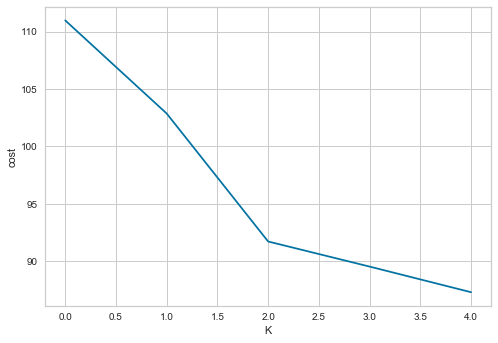

In [191]:
#Choosing optimal K value
cost = []
for num_clusters in list(range(3,8)):
    kproto = KPrototypes(n_clusters=num_clusters) 
    kproto.fit_predict(minmax_kpro, categorical=[3,4])
    cost.append(kproto.cost_)

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

In [244]:
k_pro_minmax = KPrototypes(n_clusters=4)
k_pro_minmax.fit(minmax_kpro, categorical = [3,4])
results_evaluation_kpro(k_pro_minmax, minmax_kpro)

print('The Silhouette Score is: ', silhouette_score(minmax_kpro.drop(['Category','Geographical zone'],1), k_pro_a.labels_, metric='euclidean'))
print('The Calinski Harabasz Score is: ', calinski_harabasz_score(minmax_kpro.drop(['Category','Geographical zone'],1), k_pro_a.labels_))
print('The Davies Douldin Score is: ', davies_bouldin_score(minmax_kpro.drop(['Category','Geographical zone'],1), k_pro_a.labels_))

CLUSTERING DIVISION:
 0    514
1    150
2    119
3    118
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance
Cluster,,,,,,,,,,
0,121550.45,13541.09,12.24,77.30,87.32,1.56,89.88,0.66,69.92,38.08
1,159086.94,9239.22,7.81,74.99,88.24,1.63,39.52,0.36,64.65,32.06
2,90213.41,5021.16,5.21,57.41,65.85,1.11,29.36,0.43,49.69,29.71
3,104564.50,6380.20,9.40,68.34,80.40,1.41,25.80,0.42,58.71,6.08


The Silhouette Score is:  0.04416171861131309
The Calinski Harabasz Score is:  91.40698882964739
The Davies Douldin Score is:  2.2402139222175173


In [245]:
df_k_pro_minmax = groupby_domains.copy()
df_k_pro_minmax['Cluster'] = k_pro_a.labels_
df_k_pro_minmax.groupby('Cluster').mean()

,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance
Cluster,,,,,,,,,,
0,122866.51,25346.56,23.93,77.89,91.77,1.56,156.08,0.54,72.01,32.18
1,116712.77,3531.41,3.11,69.20,77.49,1.42,24.64,0.52,59.56,30.63
2,103301.85,45747.52,52.12,78.57,91.45,1.63,184.94,0.42,75.73,33.42
3,130555.89,12581.64,11.61,76.95,89.70,1.56,77.18,0.61,69.52,33.44


In [249]:
df_k_pro_minmax[df_k_pro_minmax['Cluster']==3]['Geographical zone'].value_counts()

South America    168
West Europe       35
Asia              34
North America     16
East Europe       11
Arabia             3
Australia          1
Name: Geographical zone, dtype: int64

- Without MINMAX

<function matplotlib.pyplot.show(*args, **kw)>

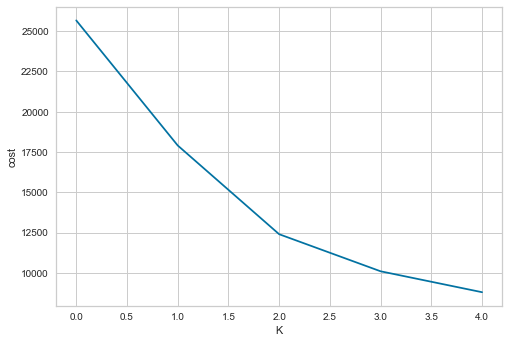

In [138]:
#Choosing optimal K value
cost = []
for num_clusters in list(range(3,8)):
    kproto = KPrototypes(n_clusters=num_clusters) 
    kproto.fit_predict(k_pro, categorical=[3,4])
    cost.append(kproto.cost_)

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

In [263]:
k_pro_a = KPrototypes(n_clusters=6)
k_pro_a.fit(k_pro, categorical = [3,4])
results_evaluation_kpro(k_pro_a, k_pro)

print('The Silhouette Score is: ', silhouette_score(k_pro.drop(['Category','Geographical zone'],1), k_pro_a.labels_, metric='euclidean'))
print('The Calinski Harabasz Score is: ', calinski_harabasz_score(k_pro.drop(['Category','Geographical zone'],1), k_pro_a.labels_))
print('The Davies Douldin Score is: ', davies_bouldin_score(k_pro.drop(['Category','Geographical zone'],1), k_pro_a.labels_))

CLUSTERING DIVISION:
 2    335
1    254
0    148
4    121
5     37
3      6
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance
Cluster,,,,,,,,,,
0,128853.22,13631.02,13.90,77.21,90.84,1.56,85.82,0.64,70.16,35.20
1,114590.60,8459.18,7.32,74.58,85.80,1.52,55.53,0.57,66.84,32.15
2,123755.30,2575.88,1.99,67.84,75.13,1.40,16.28,0.50,57.37,29.79
3,105959.55,70623.67,75.31,84.62,97.09,1.78,415.33,0.50,80.12,31.08
4,116179.03,22011.74,22.48,77.63,91.11,1.54,152.00,0.56,71.30,32.24
5,137466.08,42710.30,38.78,77.86,92.72,1.64,149.20,0.42,75.30,32.25


The Silhouette Score is:  0.5574264131953095
The Calinski Harabasz Score is:  2647.302413162133
The Davies Douldin Score is:  0.5414520075033886


In [145]:
def results_evaluation_kpro(model, data):

    #This function has 2 arguments:
    #-model: to define de Clusters and the scores
    #-data: the data I´m working with, to calculate the scores
  

    print('CLUSTERING DIVISION:\n', pd.DataFrame(model.labels_)[0].value_counts())
    
    new_df = groupby_domains.copy()
    new_df['Cluster'] = model.labels_
    display(new_df.groupby('Cluster').mean())

CLUSTERING DIVISION:
 1    468
3    268
0    141
2     24

In [264]:
new_df_k_pro = groupby_domains.copy()
new_df_k_pro['Cluster'] = k_pro_a.labels_
new_df_k_pro.groupby('Cluster').mean()

,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance
Cluster,,,,,,,,,,
0,128853.22,13631.02,13.90,77.21,90.84,1.56,85.82,0.64,70.16,35.20
1,114590.60,8459.18,7.32,74.58,85.80,1.52,55.53,0.57,66.84,32.15
2,123755.30,2575.88,1.99,67.84,75.13,1.40,16.28,0.50,57.37,29.79
3,105959.55,70623.67,75.31,84.62,97.09,1.78,415.33,0.50,80.12,31.08
4,116179.03,22011.74,22.48,77.63,91.11,1.54,152.00,0.56,71.30,32.24
5,137466.08,42710.30,38.78,77.86,92.72,1.64,149.20,0.42,75.30,32.25


In [278]:
new_df_k_pro[new_df_k_pro['Cluster']==0]['Geographical zone'].value_counts()

South America    90
Asia             20
West Europe      20
North America     9
East Europe       7
Arabia            1
Australia         1
Name: Geographical zone, dtype: int64

In [168]:
new_df_k_pro[new_df_k_pro['Cluster']==3].describe()

,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Cluster
count,260.00,260.00,260.00,260.00,260.00,260.00,260.00,260.00,260.00,260.00,260.00
mean,126011.47,12094.68,11.78,77.11,89.84,1.56,75.69,0.61,69.54,33.28,3.00
std,180763.42,14882.14,2.94,12.44,11.85,0.23,98.92,0.35,11.22,27.25,0.00
min,20220.81,271.86,7.59,15.39,20.05,0.34,0.29,0.00,14.59,0.15,3.00
25%,36385.42,3932.90,9.10,72.09,87.28,1.51,18.11,0.36,63.61,3.57,3.00
50%,64317.94,7177.87,11.61,80.89,94.83,1.60,37.36,0.57,72.30,58.61,3.00
75%,134062.57,13680.68,13.94,85.47,97.12,1.69,95.44,0.84,77.20,58.61,3.00
max,1732798.15,124798.83,17.84,95.24,99.98,2.21,895.53,1.81,91.83,58.61,3.00


In [251]:
results_evaluation(k_pro_a, groupby_domains_clustering)


CLUSTERING DIVISION:
 1    468
3    268
0    141
2     24
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance
Cluster,,,,,,,,,,
0,122866.51,25346.56,23.93,77.89,91.77,1.56,156.08,0.54,72.01,32.18
1,116712.77,3531.41,3.11,69.20,77.49,1.42,24.64,0.52,59.56,30.63
2,103301.85,45747.52,52.12,78.57,91.45,1.63,184.94,0.42,75.73,33.42
3,130555.89,12581.64,11.61,76.95,89.70,1.56,77.18,0.61,69.52,33.44


The Silhouette Score is:  0.529161273346998
The Calinski Harabasz Score is:  1753.8111869207519
The Davies Douldin Score is:  0.592600065065219


In [24]:
results_evaluation(k_pro, groupby_domains_clustering)


CLUSTERING DIVISION:
 0    380
2    318
1    125
3     78
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance
Cluster,,,,,,,,,,
0,136841.69,13041.48,11.58,81.86,91.64,1.63,90.37,0.68,73.53,58.61
1,72883.27,3361.34,4.51,46.95,56.99,1.05,16.93,0.32,37.47,3.55
2,124922.81,12025.03,12.08,78.45,90.87,1.60,61.03,0.52,70.73,4.24
3,109977.88,6365.35,4.92,50.74,58.94,1.10,35.89,0.40,43.05,58.61


In [29]:
print('The Silhouette Score is: ', silhouette_score(groupby_domains_clustering.drop(['Category','Country'],1), k_pro.labels_, metric='euclidean'))
print('The Calinski Harabasz Score is: ', calinski_harabasz_score(groupby_domains_clustering.drop(['Category','Country'],1), k_pro.labels_))
print('The Davies Douldin Score is: ', davies_bouldin_score(groupby_domains_clustering.drop(['Category','Country'],1), k_pro.labels_))

The Silhouette Score is:  0.5108028489299699
The Calinski Harabasz Score is:  1420.7893598808778
The Davies Douldin Score is:  0.7444640661182405


In [19]:
pd.DataFrame(k_pro.labels_)[0].value_counts()

0    380
2    318
1    125
3     78
Name: 0, dtype: int64

In [32]:
new_df = groupby_domains_clustering.copy()
new_df['Cluster'] = k_pro.labels_
display(new_df.groupby('Cluster').mean())

,Format Fill Rate,CPM,CTR,50% View Rate,Category importance
Cluster,,,,,
0,11.58,1.63,0.68,73.53,58.61
1,4.51,1.05,0.32,37.47,3.55
2,12.08,1.60,0.52,70.73,4.24
3,4.92,1.10,0.40,43.05,58.61


In [41]:
new_df[new_df['Cluster']==3]['Category'].unique()

array(['News & Portals'], dtype=object)

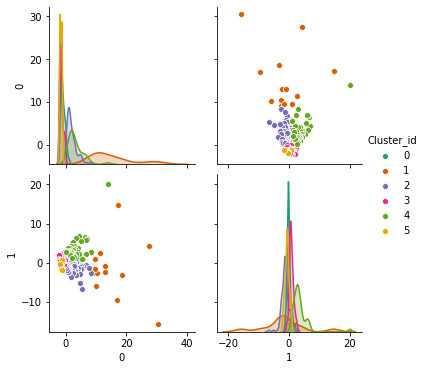

In [19]:
groupby_domains_kprototypes = pd.DataFrame(pca_2_robust)
groupby_domains_kprototypes['Cluster_id']=k_pro.labels_
sns.pairplot(groupby_domains_kprototypes,hue='Cluster_id',palette='Dark2',diag_kind='kde')

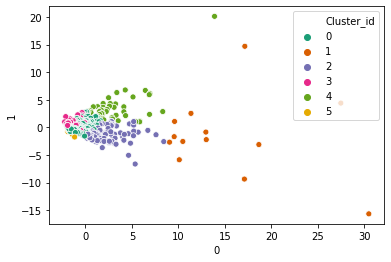

In [23]:
sns.scatterplot(groupby_domains_kprototypes[0], groupby_domains_kprototypes[1], hue = groupby_domains_kprototypes['Cluster_id'], palette='Dark2')

In [24]:
print('The Silhouette Score is:', silhouette_score(robust, k_pro.labels_))
print('The Calinski Harabasz Score is:', calinski_harabasz_score(robust, k_pro.labels_))

The Silhouette Score is: 0.3045945135858173
The Calinski Harabasz Score is: 176.55445241902606


## DETECTING OUTLIERS

In [169]:
Q1 = groupby_domains['Format Loads'].quantile(0.25)
Q3 = groupby_domains['Format Loads'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

94953.21536796537


In [173]:
no_outliers = groupby_domains.copy()[~((groupby_domains['Format Loads']< (Q1 - 1.5 * IQR)) |(groupby_domains['Format Loads']> (Q3 + 1.5 * IQR)))]
no_outliers.dropna(inplace=True)
no_outliers['Outlier']=0

In [174]:
outliers = groupby_domains.merge(no_outliers,how='left').fillna(value=1)
outliers = outliers[outliers['Outlier']==1]
outliers.drop('Outlier',1,inplace=True)
no_outliers.drop('Outlier',1,inplace=True)

In [179]:
no_outliers.shape

(809, 14)

In [178]:
outliers.shape

(92, 14)

In [8]:
#from sklearn import manifold
#from sklearn.metrics import euclidean_distances

#similarities = euclidean_distances(groupby_domains)

#mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=1)

#pos = mds.fit(similarities).embedding_

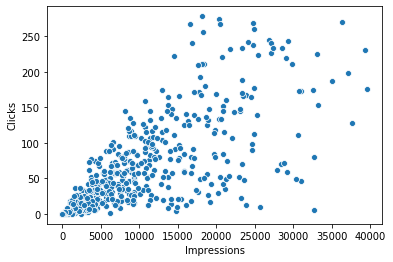

In [132]:
sns.scatterplot(no_outliers['Impressions'], no_outliers['Clicks'])

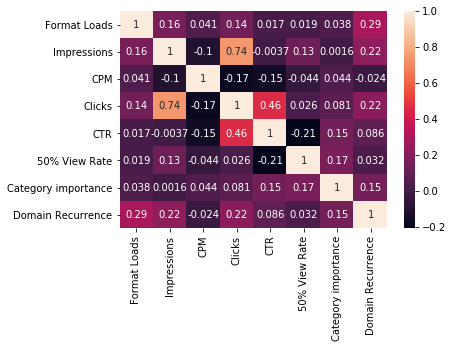

In [125]:
sns.heatmap(no_outliers.corr(), annot=True)

In [153]:
new_variable.shape

(563, 1)

In [188]:
pca=PCA(n_components=1)
new_variable = pca.fit_transform(no_outliers[['Impressions','Clicks']])
print(pca.explained_variance_ratio_)
no_outliers_modified = no_outliers.copy()
no_outliers_modified['PCA: Impressions/Clicks'] = new_variable
no_outliers_modified.drop(['Impressions', 'Clicks'], 1, inplace=True)

[0.9999749]


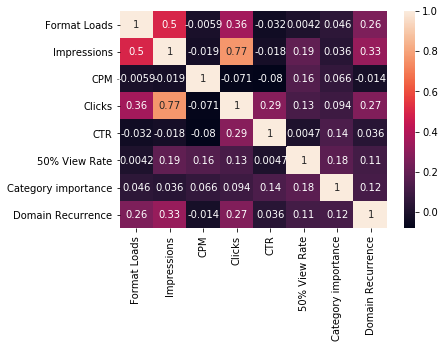

In [126]:
sns.heatmap(groupby_domains.corr(), annot=True)

In [260]:
groupby_domains_one_hot =pd.get_dummies(groupby_domains,columns=['Category','Geographical zone'])
groupby_domains_clustering= groupby_domains.drop(['Domain','Format Loads', 'Impressions', 'Clicks',
                                                   'Geographical zone importance','Viewability Rate', 'Efficiency Rate', 'Category importance', 'Country',
                                                         '50% View Rate'], 1)
minmax = MinMaxScaler().fit_transform(groupby_domains_clustering)


In [278]:
from kmodes.kmodes import KModes
modes = pd.get_dummies(groupby_domains,columns=['Category','Geographical zone']).iloc[:,13:]
kmodes=KModes()

In [271]:
groupby_domains_clustering= groupby_domains.drop(['Domain','Format Loads', 'Impressions', 'Clicks',
                                                   'Viewability Rate', 'Efficiency Rate', 'Country','Category', 'Geographical zone',  
                                                         '50% View Rate'], 1)
minmax = MinMaxScaler().fit_transform(groupby_domains_clustering)


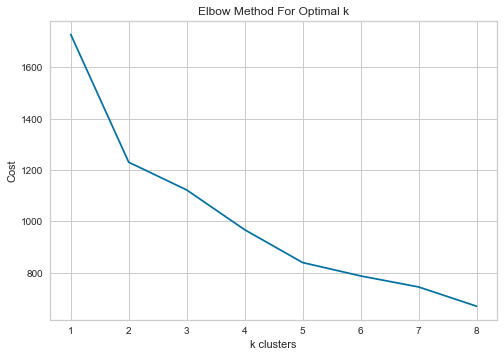

In [280]:
cost = []
K = range(1,9)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1)
    kmode.fit_predict(modes)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('k clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

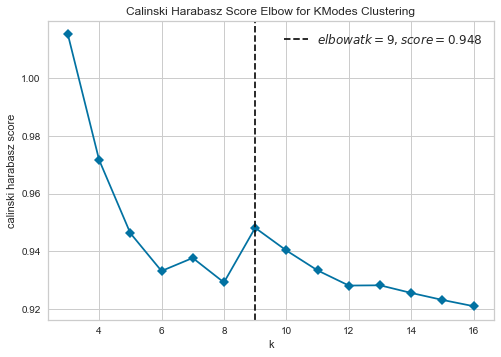

C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Usuario\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


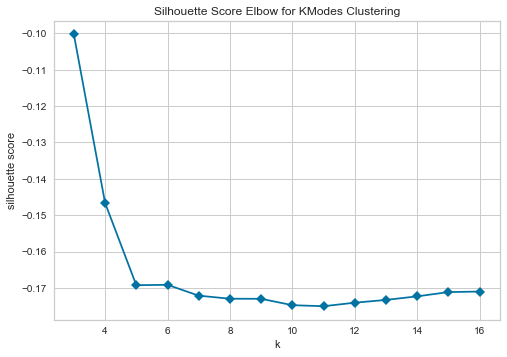

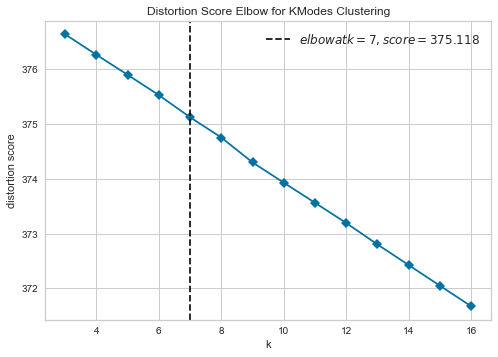

In [272]:
kmodes=KModes()
visualization_clusters(minmax, kmodes)

In [266]:
km =  KModes(n_clusters=5) 
km.fit(modes)
results_evaluation(km, groupby_domains_clustering)


CLUSTERING DIVISION:
 0    502
1    122
2    108
3     94
4     75
Name: 0, dtype: int64


,Format Loads,Impressions,Format Fill Rate,Viewability Rate,Efficiency Rate,CPM,Clicks,CTR,50% View Rate,Category importance,Geographical zone importance
Cluster,,,,,,,,,,,
0,121640.10,12269.59,11.01,76.01,85.89,1.54,80.16,0.63,68.90,37.64,50.99
1,146157.13,8143.74,7.31,71.46,83.82,1.51,43.86,0.40,60.37,27.14,12.71
2,122016.61,7989.56,10.10,72.09,83.66,1.46,56.09,0.54,62.94,25.69,11.98
3,89952.96,4919.02,5.42,65.91,74.91,1.26,29.22,0.47,56.37,22.97,10.43
4,118481.39,16243.39,15.59,66.97,80.30,1.50,56.89,0.35,59.04,19.93,8.32


The Silhouette Score is:  -0.16153293109161806
The Calinski Harabasz Score is:  13.717450653656867
The Davies Douldin Score is:  6.331232457893733


In [244]:
kmdf = groupby_domains[['Category','Geographical zone']].copy()
kmdf['Cluster'] = km.labels_


In [254]:
kmdf[kmdf['Cluster']==3]['Category'].value_counts()

News & Portals         33
Tech & Gaming          12
Sports                 10
Community & Culture     9
Glamour                 5
Education & Careers     4
Movies & Television     4
Health & Wellness       3
Travel                  3
Autos                   3
Family & Parenting      2
Leisure                 2
Money & Investing       1
Food                    1
Casual Games            1
Music & Radio           1
Name: Category, dtype: int64

In [247]:
kmdf.groupby(['Cluster','Geographical zone']).count()

Category
Cluster Geographical zone          
0       Africa                    9
        Arabia                   11
        Australia                 2
        South America           480
1       Africa                    1
        Arabia                    3
        Asia                    118
2       West Europe             108
3       East Europe              94
4       North America            75

# KMEDOIDS

In [190]:
from pyclustering.cluster.kmedoids import kmedoids


In [206]:
initial_medoids = [1, 100, 200,500]
kmedoids_instance=kmedoids(minmax,initial_medoids)
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()

In [292]:
kmedoids_instance.get_cluster_encoding()

<type_encoding.CLUSTER_INDEX_LIST_SEPARATION: 1>

In [286]:
len(clusters[3])

148

In [148]:
from pyclustering.cluster.clarans import clarans;
from pyclustering.utils import timedcall;

In [181]:
len(clusters[3])

172

# CLARANS

In [166]:
from pyclustering.cluster.clarans import clarans;

from pyclustering.utils import read_sample;
from pyclustering.utils import draw_clusters;
from pyclustering.utils import timedcall;

clarans_instance = clarans(minmax, 4, 5, 8);
(ticks, result) = timedcall(clarans_instance.process);

print("Sample: ", minmax, "\t\tExecution time: ", ticks, "\n");

clusters = clarans_instance.get_clusters();
draw_clusters(sample, clusters);

Sample:  [[0.00531574 0.6266675  0.11818078 0.03427846 0.22167766]
 [0.09631269 0.67689075 0.01833266 1.         0.15268615]
 [0.03353766 0.56930228 0.10104283 0.12907321 1.        ]
 ...
 [0.12216116 0.66973984 0.0526736  1.         0.22167766]
 [0.01016783 0.62998477 0.         0.00677105 0.22167766]
 [0.02270891 0.24307086 0.09295147 1.         0.19245994]] 		Execution time:  194.3906532000001 



NameError: Drawer supports only 2d and 3d data representation

<Figure size 576x396 with 0 Axes>

### EXTERNAL VALIDATION

In [172]:
train = groupby_domains.copy()
train['Cluster'] = clusters['Cluster']
train.drop(['Domain', 'Category', 'Country','Geographical zone'],1, inplace=True)

In [173]:
X = train.drop('Cluster', 1)
y = train['Cluster']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4)

robustscaler = RobustScaler()
X_train_robust = robustscaler.fit_transform(X_train)
X_test_robust = robustscaler.fit_transform(X_test)


In [174]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score

tree=DecisionTreeClassifier(max_depth=2).fit(X_train_robust,y_train)
y_pred=tree.predict(X_test_robust)
print('TRAIN SCORES:',tree.score(X_train_robust,y_train), 'TEST SCORE:', tree.score(X_test_robust,y_test))
print('CLASSIFICATION REPORT:\n', classification_report(y_test,y_pred))
print('CONFUSION MATRIX:\n', pd.crosstab(y_test,y_pred))

TRAIN SCORES: 0.6944444444444444 TEST SCORE: 0.3185595567867036
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           1       0.16      0.36      0.22        61
           2       0.42      0.80      0.55       116
           3       0.00      0.00      0.00       107
           4       0.00      0.00      0.00        77

    accuracy                           0.32       361
   macro avg       0.14      0.29      0.19       361
weighted avg       0.16      0.32      0.21       361

CONFUSION MATRIX:
 col_0     1   2
Cluster        
1        22  39
2        23  93
3        68  39
4        27  50


C:\Users\Usuario\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
